In [42]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [43]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas option for displaying all columns
pd.options.display.max_columns = None

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# Load datasets
train = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Load time series data
train_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_test.parquet")

# Merge datasets
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 15.08it/s]


In [44]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [45]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,

In [46]:
train.shape,test.shape

((3960, 177), (20, 154))

In [47]:
train_ts.shape,test_ts.shape


((996, 97), (2, 97))

In [48]:
missing_cols=set(train)-set(test)
missing_cols.remove('sii')
missing_cols

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

In [49]:
train.isna().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            884
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                           1678
FGC-FGC_GSND                              2886
FGC-FGC_GSND_

### Feature Engineering

#####  Dropping features

In [50]:
# dropping features with equal to or more than 50% of missing values
def dropMissingValueFeatures(train,test):
    missing_train = train.isna().mean() * 100
    cols_to_drop = missing_train[missing_train >= 50].index.tolist()
    cols_to_drop+=[i for i in train.columns if 'BIA' in i]

    train=train.drop(columns=[col for col in cols_to_drop if col in train.columns], axis=1)
    test=test.drop(columns=[col for col in cols_to_drop if col in test.columns], axis=1)
    return train,test

In [51]:
train,test=dropMissingValueFeatures(train,test)

In [52]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [53]:
train.shape[1]-test.shape[1]

23

In [54]:
wa = pd.DataFrame(data=train, columns=['PCIAT-PCIAT_Total', 'sii'])
wa[pd.notna(wa['PCIAT-PCIAT_Total'])]

,PCIAT-PCIAT_Total,sii
0,55.0,2.0
1,0.0,0.0
2,28.0,0.0
3,44.0,1.0
5,34.0,1.0
...,...,...
3953,22.0,0.0
3954,33.0,1.0
3955,32.0,1.0
3957,31.0,1.0


In [55]:
train_pciatAvg=train.copy()
test_pciatAvg=test.copy()
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
train_pciatAvg['Pciat_total_min']=train_pciatAvg[pciat_columns].fillna(0).sum(axis=1)
train_pciatAvg['Pciat_total_max']=train_pciatAvg[pciat_columns].fillna(5).sum(axis=1)
train_pciatAvg['Pciat_total_avg']=(train_pciatAvg['Pciat_total_max']+train_pciatAvg['Pciat_total_min'])/2
train_pciatAvg.drop(columns=['Pciat_total_max','Pciat_total_min','PCIAT-PCIAT_Total', 'PCIAT-Season','sii'] + pciat_columns, inplace=True)

def calSii(total):
    if total<=30:
        return 0  # None
    elif 31 <= total <= 49:
        return 1  # Mild
    elif 50 <= total <= 79:
        return 2  # Moderate
    else:
        return 3  # Severe

train_pciatAvg['sii_pred']=train_pciatAvg['Pciat_total_avg'].apply(calSii)
train_pciatAvg.drop('Pciat_total_avg',axis=1)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii_pred
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,NaN,NaN,NaN,Fall,3.0,2
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,75.0,70.0,122.0,Fall,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Fall,38.0,54.0,Summer,2.0,0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0,1
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,71.0,70.0,104.0,Fall,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Winter,35.0,50.0,Fall,1.0,1
3956,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,60.0,78.0,118.0,Spring,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,NaN,NaN,NaN,Winter,0.0,2
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,79.0,99.0,116.0,Winter,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,Winter,56.0,77.0,Fall,0.0,1
3958,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,59.0,61.0,113.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,33.0,47.0,Spring,1.0,0


In [56]:
missing_train = train_pciatAvg.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [57]:
train_pciatAvg.shape,test.shape

((3960, 30), (20, 28))

In [58]:
train_pciatAvg.sample(10)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Pciat_total_avg,sii_pred
1253,Summer,10,0,Fall,59.0,Summer,18.043667,60.0,92.4,65.0,78.0,98.0,Summer,13.0,1.0,7.0,1.0,8.5,1.0,8.5,1.0,11.0,1.0,Summer,41.0,58.0,Summer,2.0,40.0,1
3839,Summer,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,2
3020,Spring,15,0,Fall,61.0,Summer,25.053491,66.5,157.6,66.0,53.0,119.0,Summer,30.0,1.0,41.0,1.0,9.0,1.0,10.0,1.0,12.0,1.0,Summer,31.0,45.0,Spring,2.0,33.0,1
3126,Fall,10,1,Spring,85.0,Winter,14.926126,55.5,65.4,70.0,79.0,108.0,Winter,30.0,1.0,6.0,0.0,5.0,0.0,5.0,0.0,9.0,1.0,Winter,36.0,51.0,Fall,0.0,26.0,0
1891,Winter,10,1,Spring,75.0,Winter,17.496889,52.5,68.6,57.0,70.0,102.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,50.0,2
566,Summer,13,1,Fall,55.0,Summer,19.950766,61.0,105.6,62.0,85.0,102.0,Summer,12.0,0.0,0.0,0.0,10.0,1.0,8.0,0.0,12.0,1.0,Summer,49.0,68.0,Summer,1.0,25.0,0
3042,Summer,9,1,NaN,NaN,Fall,19.771093,53.0,79.0,71.0,70.0,129.0,Fall,11.0,1.0,0.0,0.0,7.0,0.0,6.0,0.0,9.0,1.0,Fall,32.0,46.0,Summer,1.0,34.0,1
409,Spring,14,0,NaN,NaN,Spring,16.787111,66.5,105.6,52.0,57.0,121.0,Spring,2.0,0.0,11.0,0.0,8.0,1.0,12.0,1.0,11.0,1.0,NaN,NaN,NaN,Spring,2.0,50.0,2
1608,Summer,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,2
1907,Spring,13,1,Summer,62.0,Spring,23.628408,62.0,129.2,72.0,81.0,117.0,Spring,9.0,0.0,0.0,0.0,14.5,1.0,16.5,1.0,9.5,1.0,Spring,38.0,54.0,Spring,0.0,82.0,3


In [59]:
test.sample(5)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
14,Spring,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,2.0
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,NaN,NaN,NaN,Fall,3.0
11,Fall,11,0,Summer,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,42.0,59.0,Fall,0.0
7,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,71.0,90.0,116.0,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,NaN,NaN,NaN,Fall,2.0
8,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0


##### - Encoding Age_Group and Basic_Demos-Sex

PreInt_EduHx-computerinternet_hoursday    1.000000
Basic_Demos-Age                           0.441822
SDS-SDS_Total_T                           0.086050
SDS-SDS_Total_Raw                         0.083501
Age_Group_Adults                          0.146514
Age_Group_Children                       -0.389975
Basic_Demos-Sex_1                        -0.000579
Name: PreInt_EduHx-computerinternet_hoursday, dtype: float64


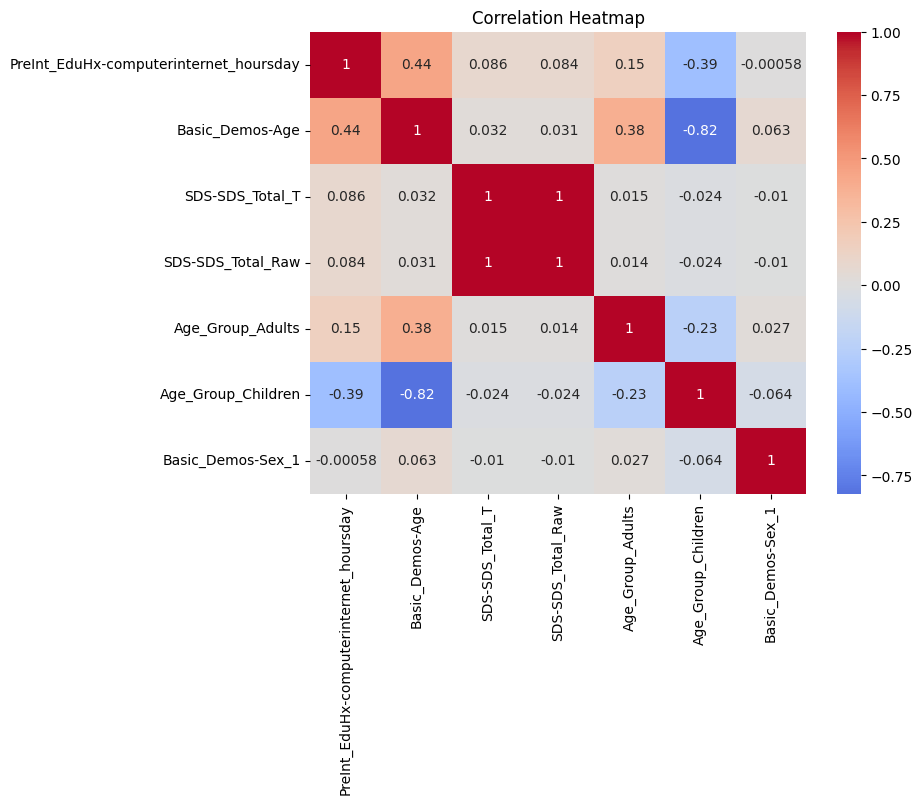

In [60]:
from sklearn.preprocessing import OneHotEncoder

# Exclude rows where 'PreInt_EduHx-computerinternet_hoursday' is NaN and select relevant columns
filtered_data = train_pciatAvg[train_pciatAvg['PreInt_EduHx-computerinternet_hoursday'].notna()][['PreInt_EduHx-computerinternet_hoursday','Basic_Demos-Age', 'Basic_Demos-Sex','SDS-SDS_Total_T', 'SDS-SDS_Total_Raw']]

# Create Age_Group
filtered_data['Age_Group'] = pd.cut(filtered_data['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])

# OneHotEncode both Age_Group and Basic_Demos-Sex
drop_enc = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Age_Group', 'Basic_Demos-Sex']
encoded_cols = drop_enc.fit_transform(filtered_data[categorical_cols])

# Create DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=drop_enc.get_feature_names_out(categorical_cols))

# Concatenate encoded columns with the original filtered_data
filtered_data = pd.concat([filtered_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Now you can drop the original categorical columns if needed
filtered_data.drop(categorical_cols, axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = filtered_data.corr()
print(filtered_data.corr()['PreInt_EduHx-computerinternet_hoursday'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()